In [13]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# ----------------------------
# Load dataset
# ----------------------------
df = pd.read_excel("uber_processed_data.xlsx")

# Fix single-column issue
if len(df.columns) == 1:
    df = df.iloc[:, 0].str.split(",", expand=True)

# Assign proper column names
df.columns = ['Unnamed: 0','fare_amount','pickup_longitude','pickup_latitude',
              'dropoff_longitude','dropoff_latitude','passenger_count','Year','Month',
              'Day','Hour','Weekday','Distance_KM','Time_of_Day_Evening','Time_of_Day_Morning',
              'Time_of_Day_Night','Distance_Category_Medium','Distance_Category_Short',
              'Distance_Category_Unknown']

# Drop unnecessary column
df.drop('Unnamed: 0', axis=1, inplace=True)

# ----------------------------
# Numeric conversion & missing values
# ----------------------------
numeric_cols = ['fare_amount','pickup_longitude','pickup_latitude','dropoff_longitude',
                'dropoff_latitude','passenger_count','Year','Month','Day','Hour','Weekday','Distance_KM']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
df[numeric_cols] = SimpleImputer(strategy='mean').fit_transform(df[numeric_cols])

# Encode categorical columns
categorical_cols = ['Time_of_Day_Evening','Time_of_Day_Morning','Time_of_Day_Night',
                    'Distance_Category_Medium','Distance_Category_Short','Distance_Category_Unknown']
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# ----------------------------
# Feature engineering
# ----------------------------
def haversine(lon1, lat1, lon2, lat2):
    R = 6371
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

df['Haversine_Dist'] = haversine(df['pickup_longitude'], df['pickup_latitude'],
                                 df['dropoff_longitude'], df['dropoff_latitude'])

# Drop raw coordinates
df.drop(['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'], axis=1, inplace=True)

# Interaction features
df['Distance_per_Hour'] = df['Distance_KM'] / (df['Hour']+1)
df['Passenger_per_KM'] = df['passenger_count'] / (df['Distance_KM']+1)
df['Total_Time_of_Day'] = df['Time_of_Day_Evening'] + df['Time_of_Day_Morning'] + df['Time_of_Day_Night']

# ----------------------------
# Features & Target
# ----------------------------
X = df.drop('fare_amount', axis=1)
y = df['fare_amount']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# ----------------------------
# Load trained model
# ----------------------------
loaded_model = xgb.Booster()
loaded_model.load_model("uber_xgb_model.json")
print("✅ Model loaded successfully")

# ----------------------------
# Evaluate Performance
# ----------------------------
# Training metrics
y_train_pred = loaded_model.predict(dtrain)
train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)

# Test metrics
y_test_pred = loaded_model.predict(dtest)
test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("\n📊 Training Performance:")
print(f"R² Score: {train_r2*100:.2f}%")
print(f"MSE: {train_mse:.2f}")

print("\n📊 Test Performance:")
print(f"R² Score: {test_r2*100:.2f}%")
print(f"MSE: {test_mse:.2f}")
print(f"MAE: {test_mae:.2f}")

✅ Model loaded successfully

📊 Training Performance:
R² Score: 84.79%
MSE: 14.60

📊 Test Performance:
R² Score: 70.17%
MSE: 31.71
MAE: 2.25


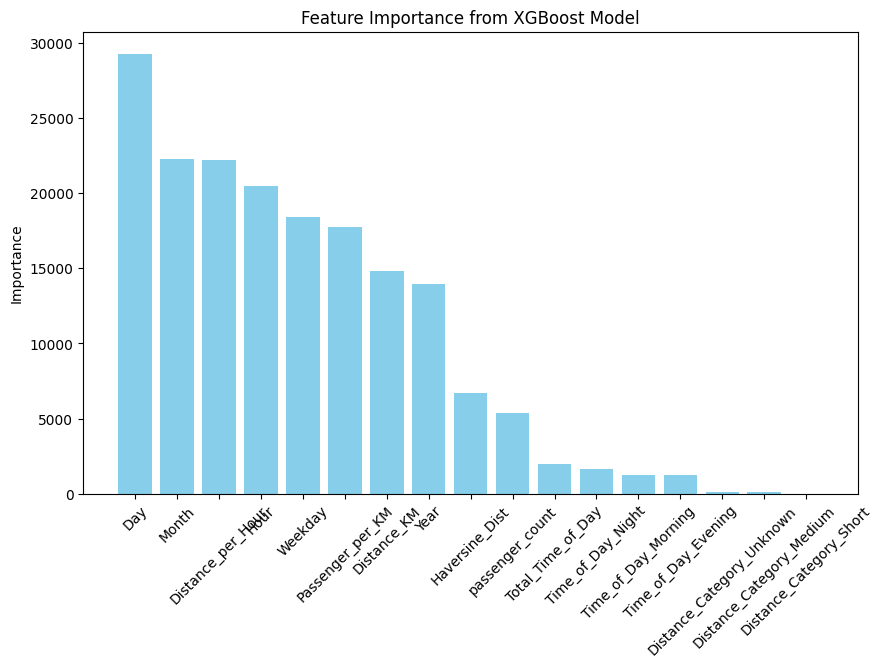


Top Features:
Day: 29269.0
Month: 22280.0
Distance_per_Hour: 22205.0
Hour: 20480.0
Weekday: 18447.0
Passenger_per_KM: 17739.0
Distance_KM: 14813.0
Year: 13934.0
Haversine_Dist: 6688.0
passenger_count: 5395.0
Total_Time_of_Day: 1988.0
Time_of_Day_Night: 1644.0
Time_of_Day_Morning: 1279.0
Time_of_Day_Evening: 1242.0
Distance_Category_Unknown: 154.0
Distance_Category_Medium: 90.0
Distance_Category_Short: 2.0


In [9]:
# ----------------------------
# Feature Importance
# ----------------------------
importance = loaded_model.get_score(importance_type='weight')
importance = dict(sorted(importance.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(10,6))
plt.bar(importance.keys(), importance.values(), color='skyblue')
plt.xticks(rotation=45)
plt.ylabel("Importance")
plt.title("Feature Importance from XGBoost Model")
plt.show()

print("\nTop Features:")
for k,v in importance.items():
    print(f"{k}: {v}")


In [10]:
# ----------------------------
# Sample Prediction on New Data
# ----------------------------
new_data = pd.DataFrame({
    'passenger_count':[2],
    'Year':[2025],
    'Month':[9],
    'Day':[12],
    'Hour':[15],
    'Weekday':[5],
    'Distance_KM':[10],
    'Time_of_Day_Evening':[0],
    'Time_of_Day_Morning':[0],
    'Time_of_Day_Night':[1],
    'Distance_Category_Medium':[1],
    'Distance_Category_Short':[0],
    'Distance_Category_Unknown':[0],
    'Haversine_Dist':[10.5],
    'Distance_per_Hour':[10/16],
    'Passenger_per_KM':[2/10],
    'Total_Time_of_Day':[1]
})

dnew = xgb.DMatrix(new_data)
predicted_fare = loaded_model.predict(dnew)
print(f"\n💰 Predicted Fare for new ride: ${predicted_fare[0]:.2f}")


💰 Predicted Fare for new ride: $31.63


In [12]:
# ===========================================
# Recommendations based on model insights:
# ===========================================

print("\n✅ Recommendations based on model insights:")

print("""
1. Pricing Strategy:
   - Trips with higher Haversine distance significantly increase fare.
   - Consider dynamic pricing for long-distance rides during peak hours.

2. Driver Incentives:
   - Trips with higher passenger-to-distance ratio are more profitable.
   - Offer incentives for rides with multiple passengers or longer distances.

3. Service Improvements:
   - Time-of-day impacts fare; morning/night trips may need additional staffing.
   - Use predicted fares to optimize vehicle allocation and reduce waiting time.

4. Operational Efficiency:
   - Monitor trips where predicted fare deviates significantly from actual fare.
   - Use predictions to identify irregular patterns or potential errors in fare calculation.
""")



✅ Recommendations based on model insights:

1. Pricing Strategy:
   - Trips with higher Haversine distance significantly increase fare.
   - Consider dynamic pricing for long-distance rides during peak hours.

2. Driver Incentives:
   - Trips with higher passenger-to-distance ratio are more profitable.
   - Offer incentives for rides with multiple passengers or longer distances.

3. Service Improvements:
   - Time-of-day impacts fare; morning/night trips may need additional staffing.
   - Use predicted fares to optimize vehicle allocation and reduce waiting time.

4. Operational Efficiency:
   - Monitor trips where predicted fare deviates significantly from actual fare.
   - Use predictions to identify irregular patterns or potential errors in fare calculation.

